Copyright (C) February 2023 Benjamin Thomas Schwertfeger   
E-Mail: development@b-schwertfeger.de  
Github: https://github.com/btschwertfeger

<h1 style="center">Performance Test for the BiasAdjustCXX command-line tool v1.8</h1>
<h3 style="centter"> ... and comparison to python-cmethods and xclim</h3> 

___
# Introduction

There are many different tools for bias correction in climate data. One of these tools is `BiasAdjustCXX`, whose performance in terms of speed of execution time will be examined in more detail. This notebook serves as a guide for reproducing the results of these tests. Within this notebook scripts are called, which install the tool, generate test data and afterwards all procedures provided in `BiasAdjustCXX` are executed to adjust the generated data sets. 

To be able to compare this with something, the Python modules `xclim` and `python-cmethods` are also used to measure their speed when applying the quantile delta mapping. 

____

## Test environment
This tests was run on MacBook Pro 13-inch 2017 (19th and 20th February of 2023)

with:
- Processor: 2.3 GHz Dual-Core Intel Core i5
- RAM: 8 GB 2133 MHz LPDDR3
- OS: MacOS Ventura 13.2.1

These performance tests have been performed while no other demanding tasks have been executed on this PC.

All tests have been executed on the same machine. The scripts `test_performance_*.sh` were used for this purpose. The input data sets were randomly generated, this can be recreated using the script `scripts/generate_test_data.py`. All datasets have exactly 10950 float values per grid cell, so this is comparable to 30 years of daily temperature values. A seed was set so that re-execution would generate the same data. 

____
## Requirements

To run the python modules, python==3.10.18 is required, since this is the newest version, that `xclim` supports.

```bash
python3 -m venv test_performance_venv
source test_performance_venv/bin/activate
python3 -m pip install -r requirements.txt
``` 

For the compilation of BiasAdjustCXX the following libraries are needed:
- NetCDF-4 C library ([How to install NetCDF-4 C](https://docs.geoserver.org/stable/en/user/extensions/netcdf-out/nc4.html))
- CMake v3.10+ ([How to install CMake](https://cmake.org/install/))

____
## Table of contents

1. Download and compilation BiasAdjustCXX v1.8
2. Generate test data sets
3. Run the performance tests for BiasAdjustCXX v1.8, python-cmethods v0.6.1 and xclim v0.40.0
4. Evaluation of the results
    
    4.1 Results of BiasAdjustCXX


    4.2 Results of python-cmethods (QM and QDM)
    
    
    4.3 Results of xclim (QDM)
    
    
    4.4 Comparison of the execution time of QDM

___
## Abbreviations

|Phrase|Definitiion|
|-----|------|
|DM|Delta Method|
|LS|Linear Scaling|
|VS|Variance Scaling|
|QM|Quantile Mapping|
|QDM|Quantile Delta Mapping|

____
## 1. Download and compile the BiasAdjustCXX tool (v1.8)

In [21]:
! ./install_BiasAdjustCXX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2909k  100 2909k    0     0   712k      0  0:00:04  0:00:04 --:--:--  714k


The BiasAdjustCXX tool is now compiled and can be executed.

____
## 2. Generate test data sets

In [ ]:
%%bash

python3 -m pip install xarray numpy
python3 scripts/generate_test_data.py 

The following cells shows how such a generated data set can look like:

In [1]:
import xarray as xr 
xr.open_dataset('input_data/obsh-10x10.nc')


<xarray.Dataset>
Dimensions:  (time: 10950, lat: 10, lon: 10)
Coordinates:
  * time     (time) object 1971-01-01 00:00:00 ... 2000-12-31 00:00:00
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    dummy    (time, lat, lon) float64 ...

____
## 3. Run the performance tests for BiasAdjustCXX v1.8, python-cmethods v0.6.1 and xclim v0.40.0


In [ ]:
%% bash
# make the *.sh files executable:
cmod +x *.sh

# BiasAdjustCXX
./test_performance_BiasAdjustCXX.sh

#= For the `python-cmethods`-module QM and QDM are tested
#= For the `xclim`-module only QDM is tested 
#=> because the other fuctions are some kind of different to the ones implemented in `BiasAdjustcXX` 

# python-cmethods python module
./test_performance_xclim_qdm.sh

# xclim python module
./test_performance_python-cmethods_qdm.sh


____
## 4. Evaluation of the results 


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

import warnings
warnings.filterwarnings('ignore')


In [45]:
path = 'performance_results/'
# Results from the performance tests of BiasAdjustCXX 
cxx_dm = pd.read_csv(f'{path}performance_BiasAdjustCXX_method-delta_method.csv')
cxx_ls = pd.read_csv(f'{path}performance_BiasAdjustCXX_method-linear_scaling.csv')
cxx_vs = pd.read_csv(f'{path}performance_BiasAdjustCXX_method-variance_scaling.csv')
cxx_qm = pd.read_csv(f'{path}performance_BiasAdjustCXX_method-quantile_mapping.csv')
cxx_qdm = pd.read_csv(f'{path}performance_BiasAdjustCXX_method-quantile_delta_mapping.csv')

# Results from the performance tests of `python-cmethods` Quantile Mapping (QM) and Quantile Delta Mapping (QDM)
pycmethods_qm = pd.read_csv(f'{path}performance_python-cmethods_method-quantile_mapping.csv')
pycmethods_qdm = pd.read_csv(f'{path}performance_python-cmethods_method-quantile_delta_mapping.csv')

# Result from the performance test of `xclim` Quantile Delta Mapping (QDM)
xclim_qdm = pd.read_csv(f'{path}performance_xclim_method-quantile_delta_mapping.csv')


### 4.1 Results of BiasAdjustCXX

Since this was tested on a dual core processor, it is not surprising that executionn time to calculate the corrected datasets does not decrease much when more than 2 jobs are used. 


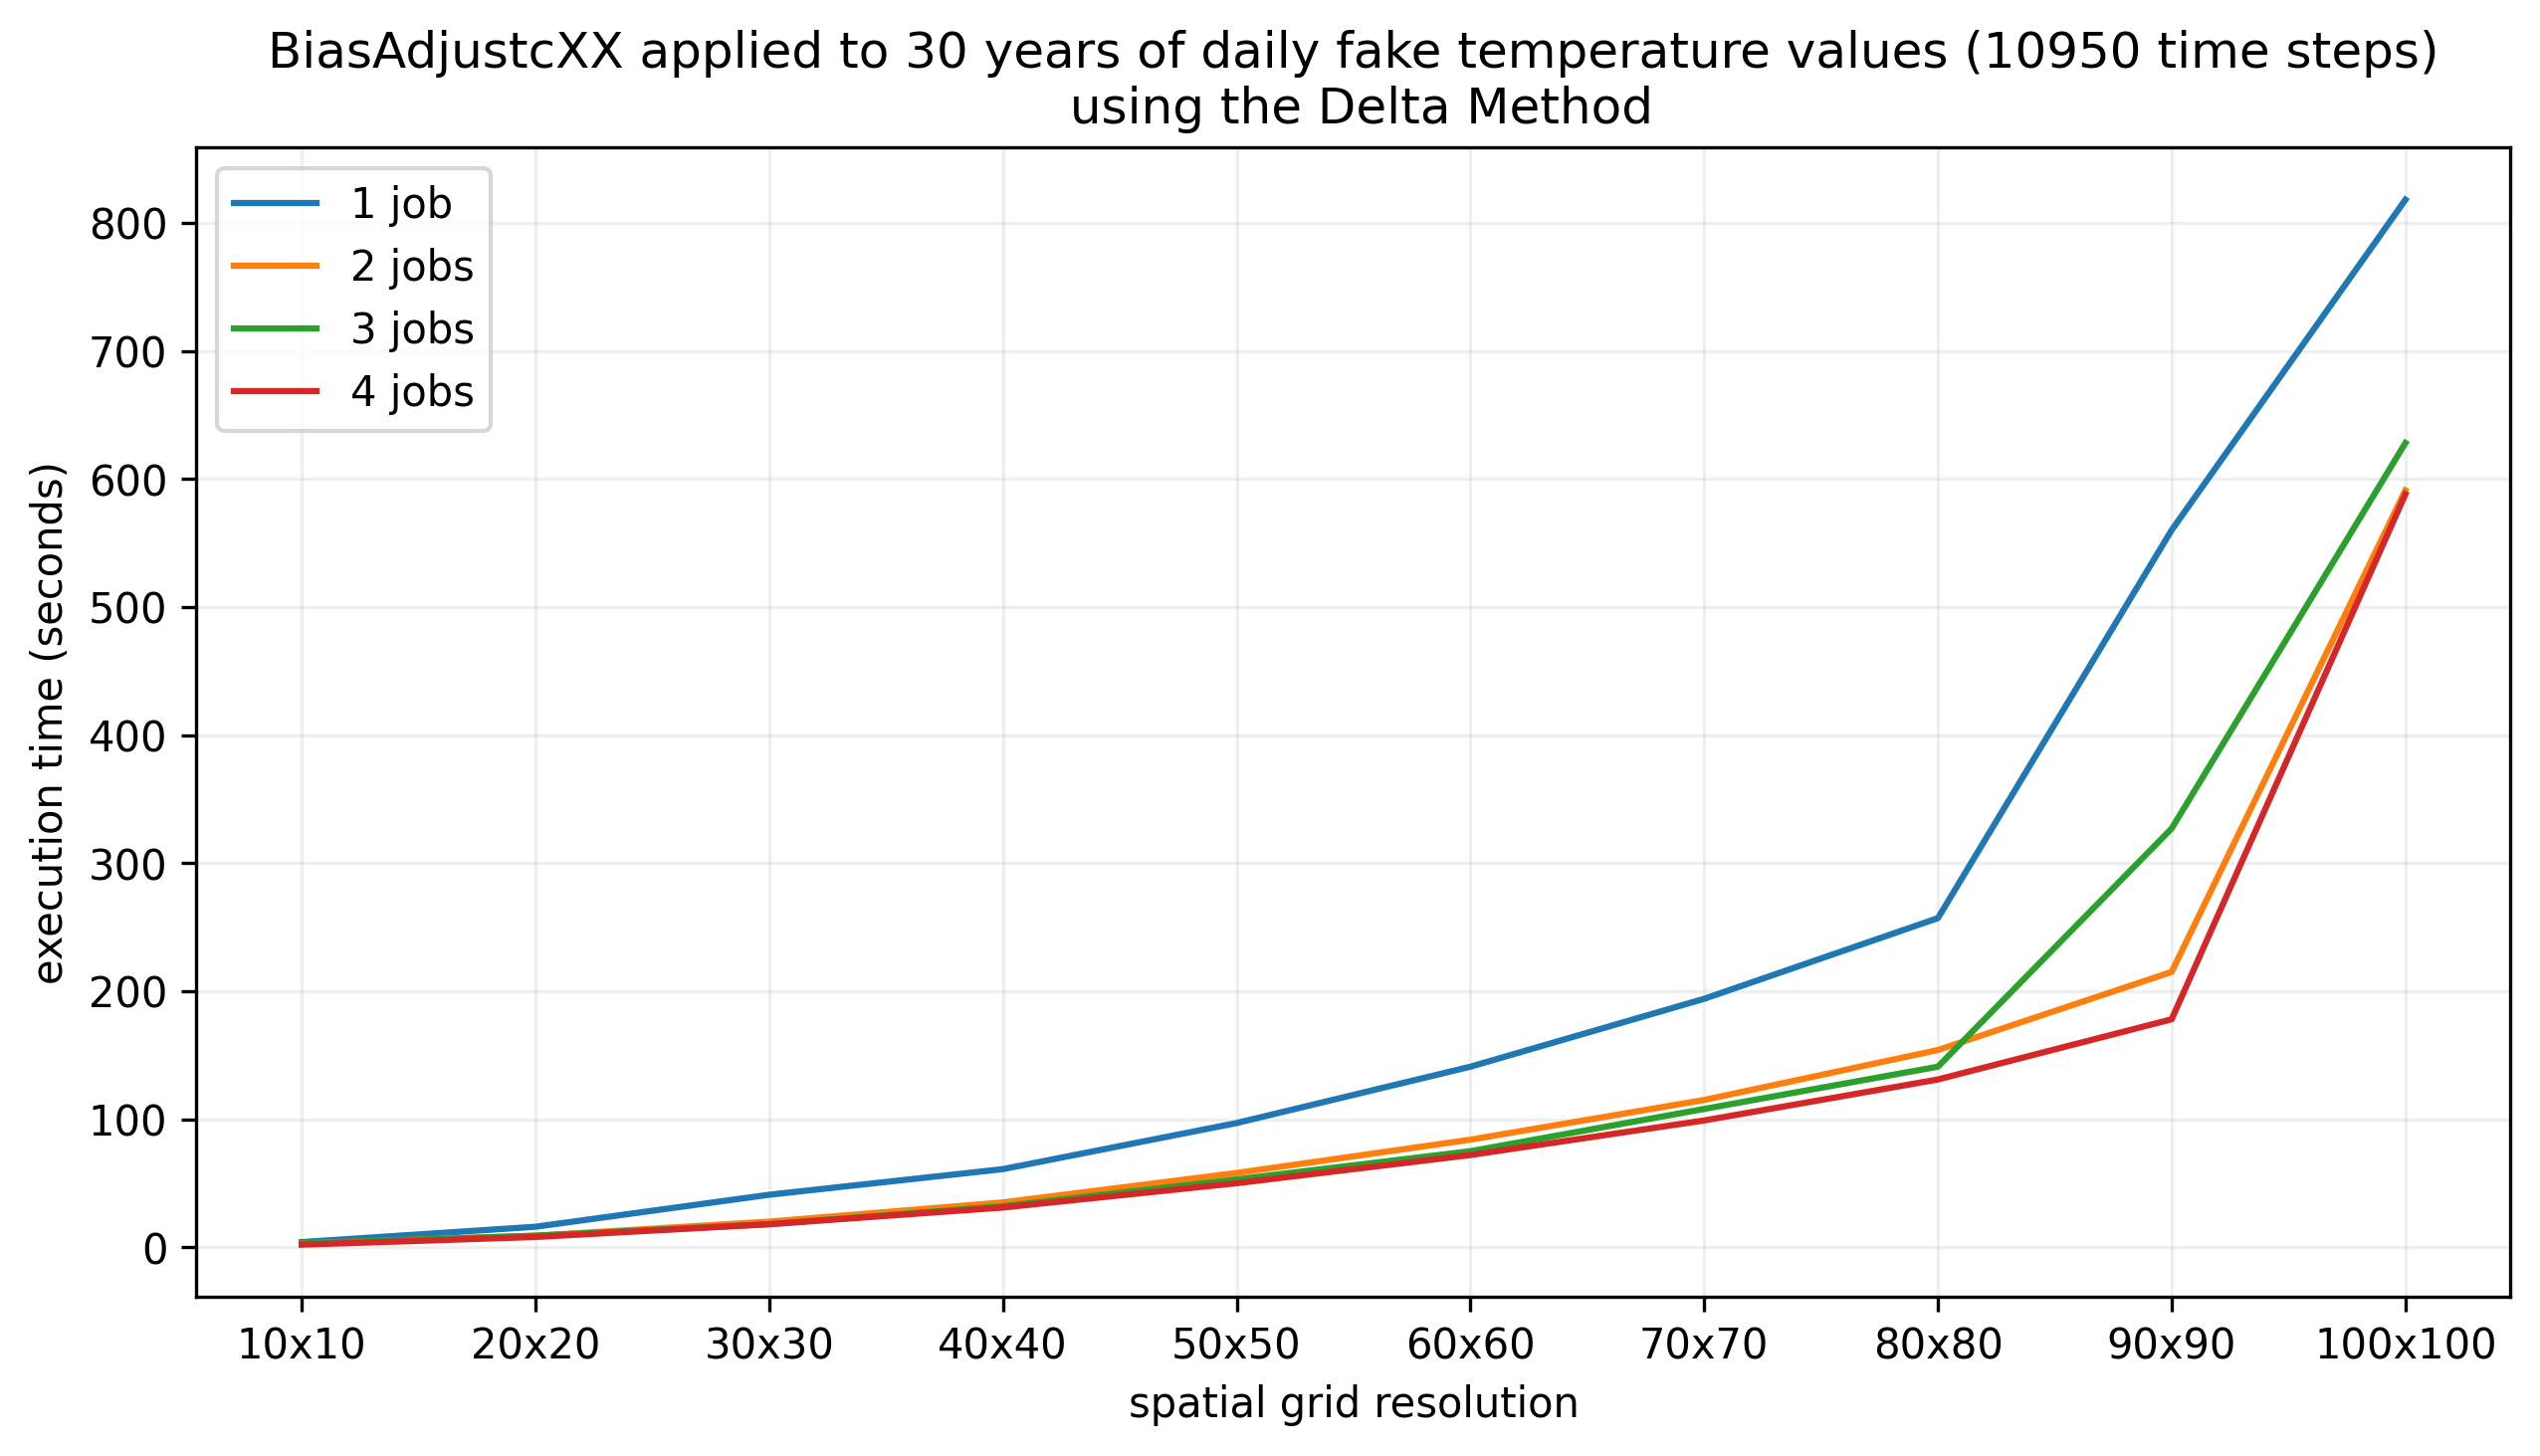

In [46]:
plt.figure(figsize=(10,5), dpi=300)

ax = plt.gca()
cxx_dm.groupby('jobs').plot(x='resolution', y='time (seconds)', ax=ax)
ax.legend([ '1 job', '2 jobs', '3 jobs', '4 jobs']);

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([f'{x}x{x}' for x in range(0,101,10)])
plt.grid(alpha=.2)

plt.ylabel('execution time (seconds)')
plt.xlabel('spatial grid resolution')
plt.title('BiasAdjustcXX applied to 30 years of daily fake temperature values (10950 time steps)\n using the Delta Method');

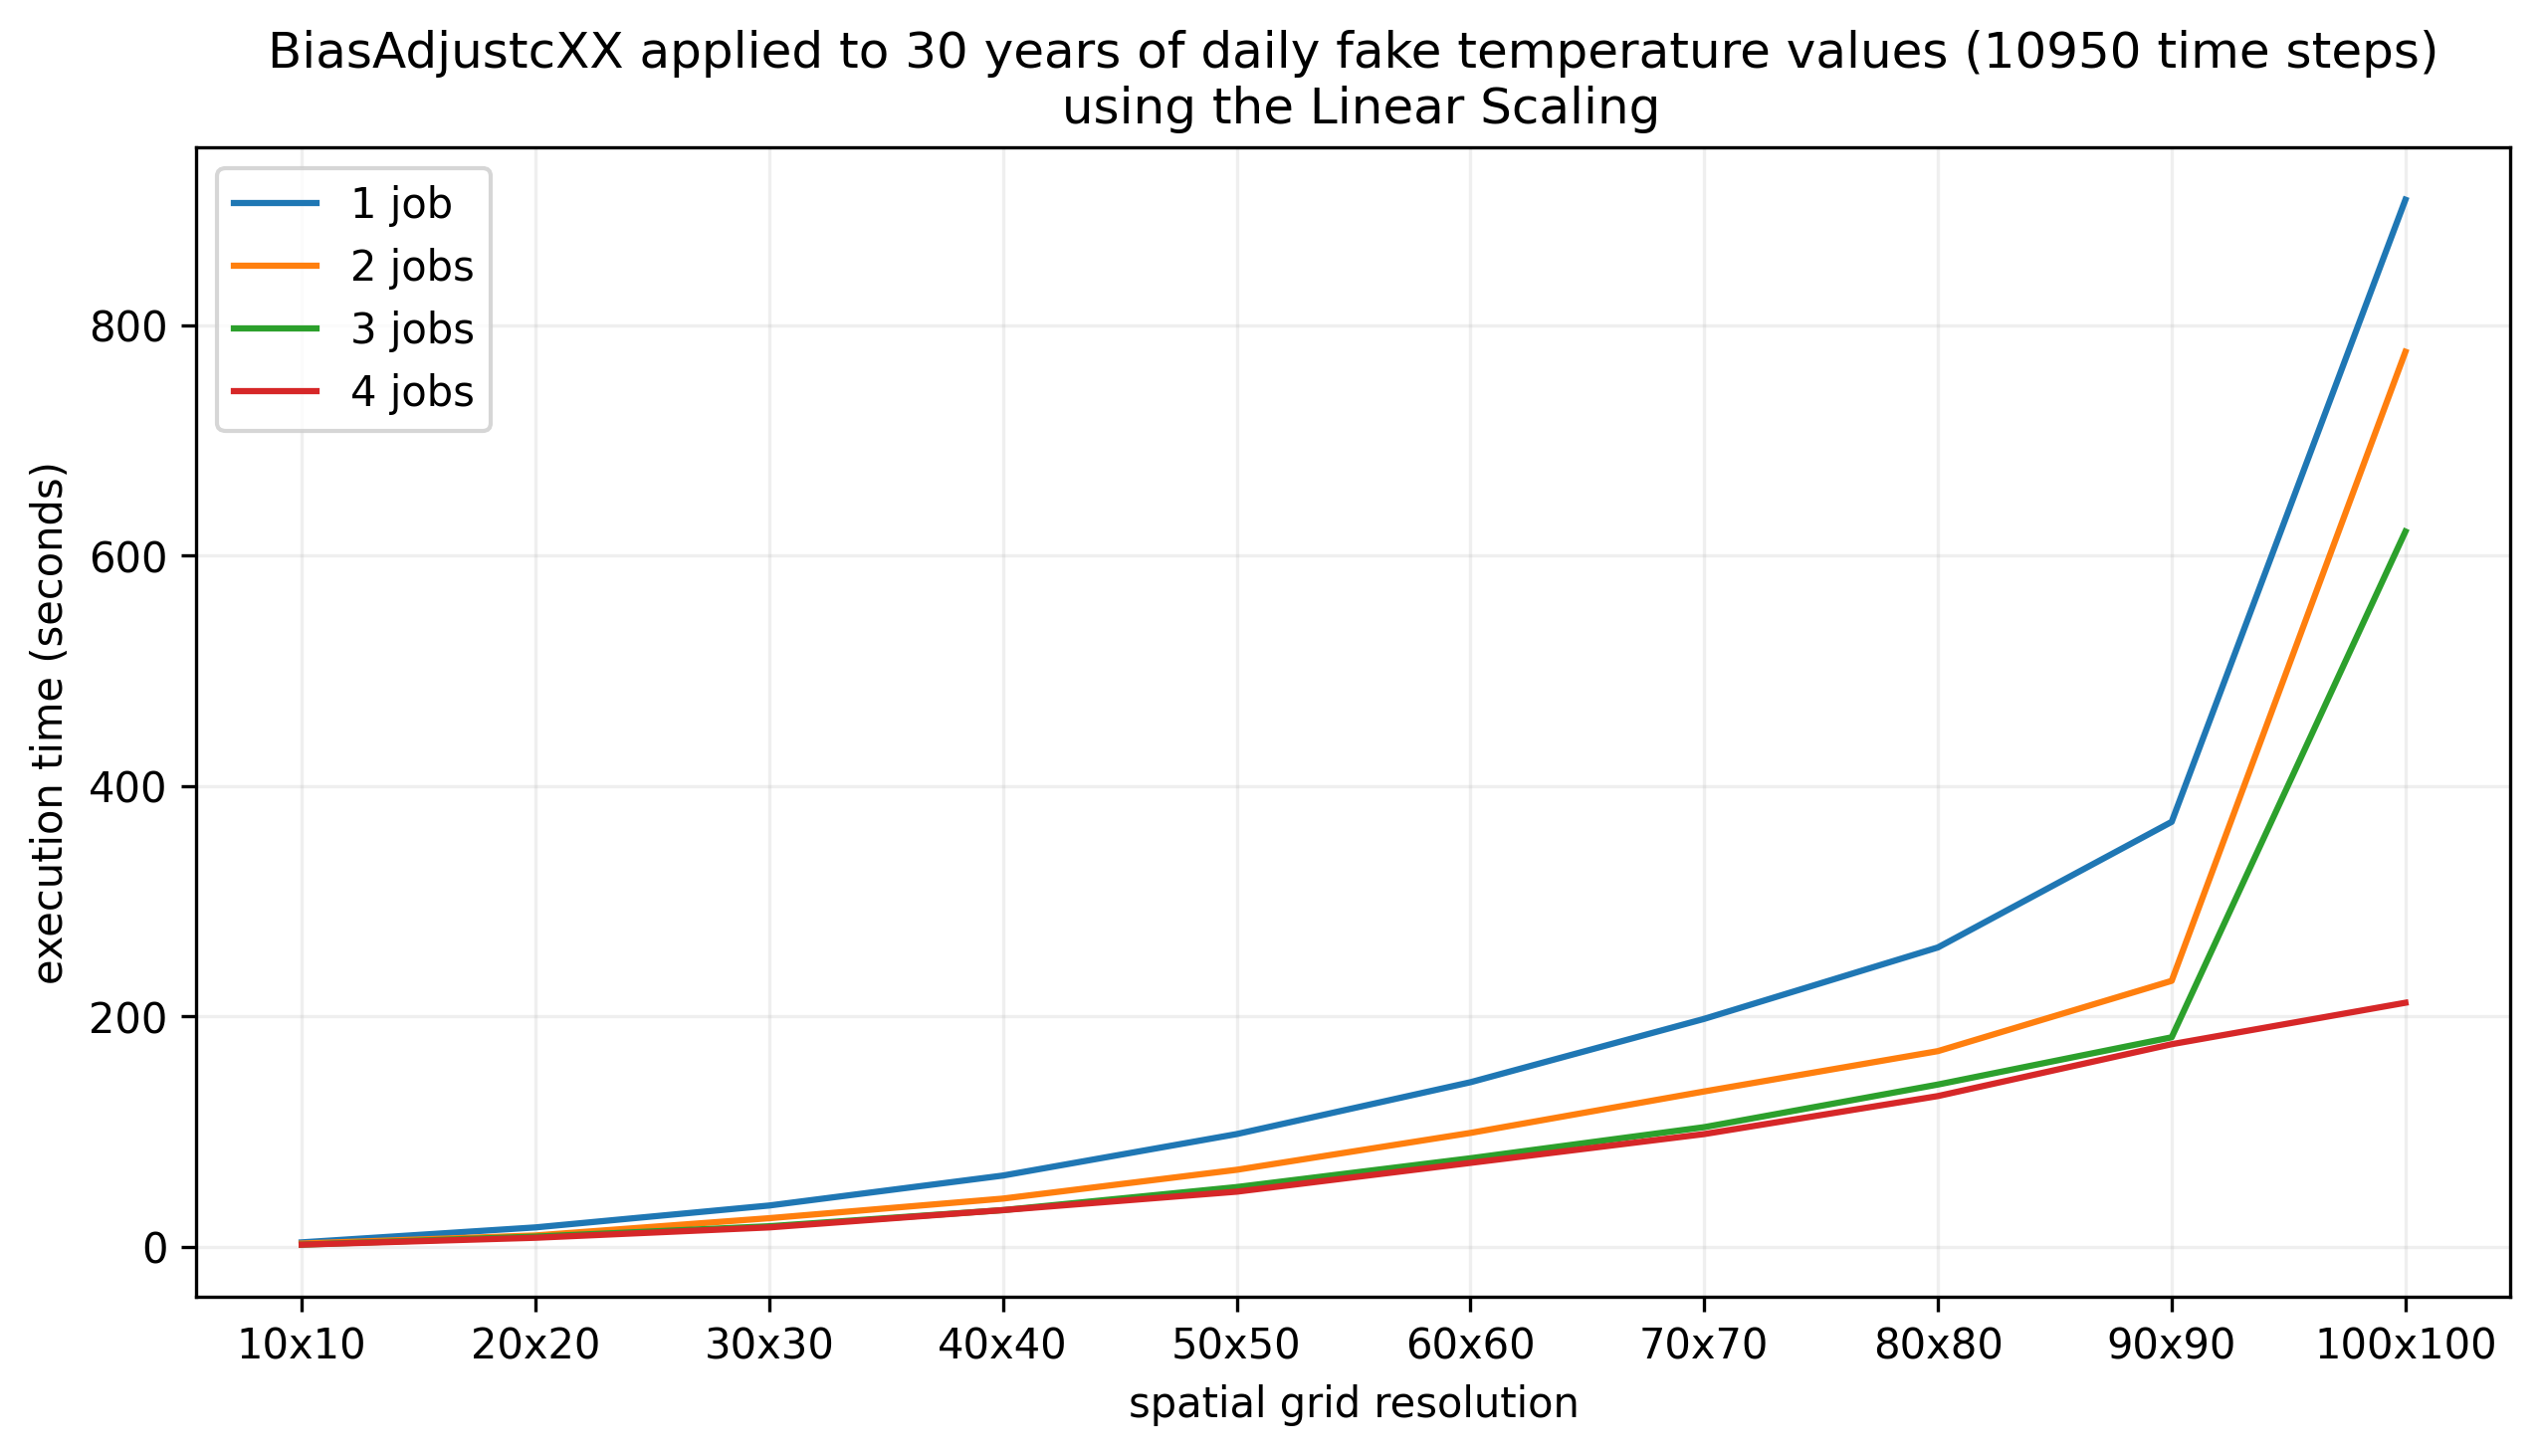

In [47]:
plt.figure(figsize=(10,5), dpi=300)

ax = plt.gca()
cxx_ls.groupby('jobs').plot(x='resolution', y='time (seconds)', ax=ax)
ax.legend([ '1 job', '2 jobs', '3 jobs', '4 jobs']);

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([f'{x}x{x}' for x in range(0,101,10)])
plt.grid(alpha=.2)

plt.ylabel('execution time (seconds)')
plt.xlabel('spatial grid resolution')
plt.title('BiasAdjustcXX applied to 30 years of daily fake temperature values (10950 time steps)\n using the Linear Scaling');

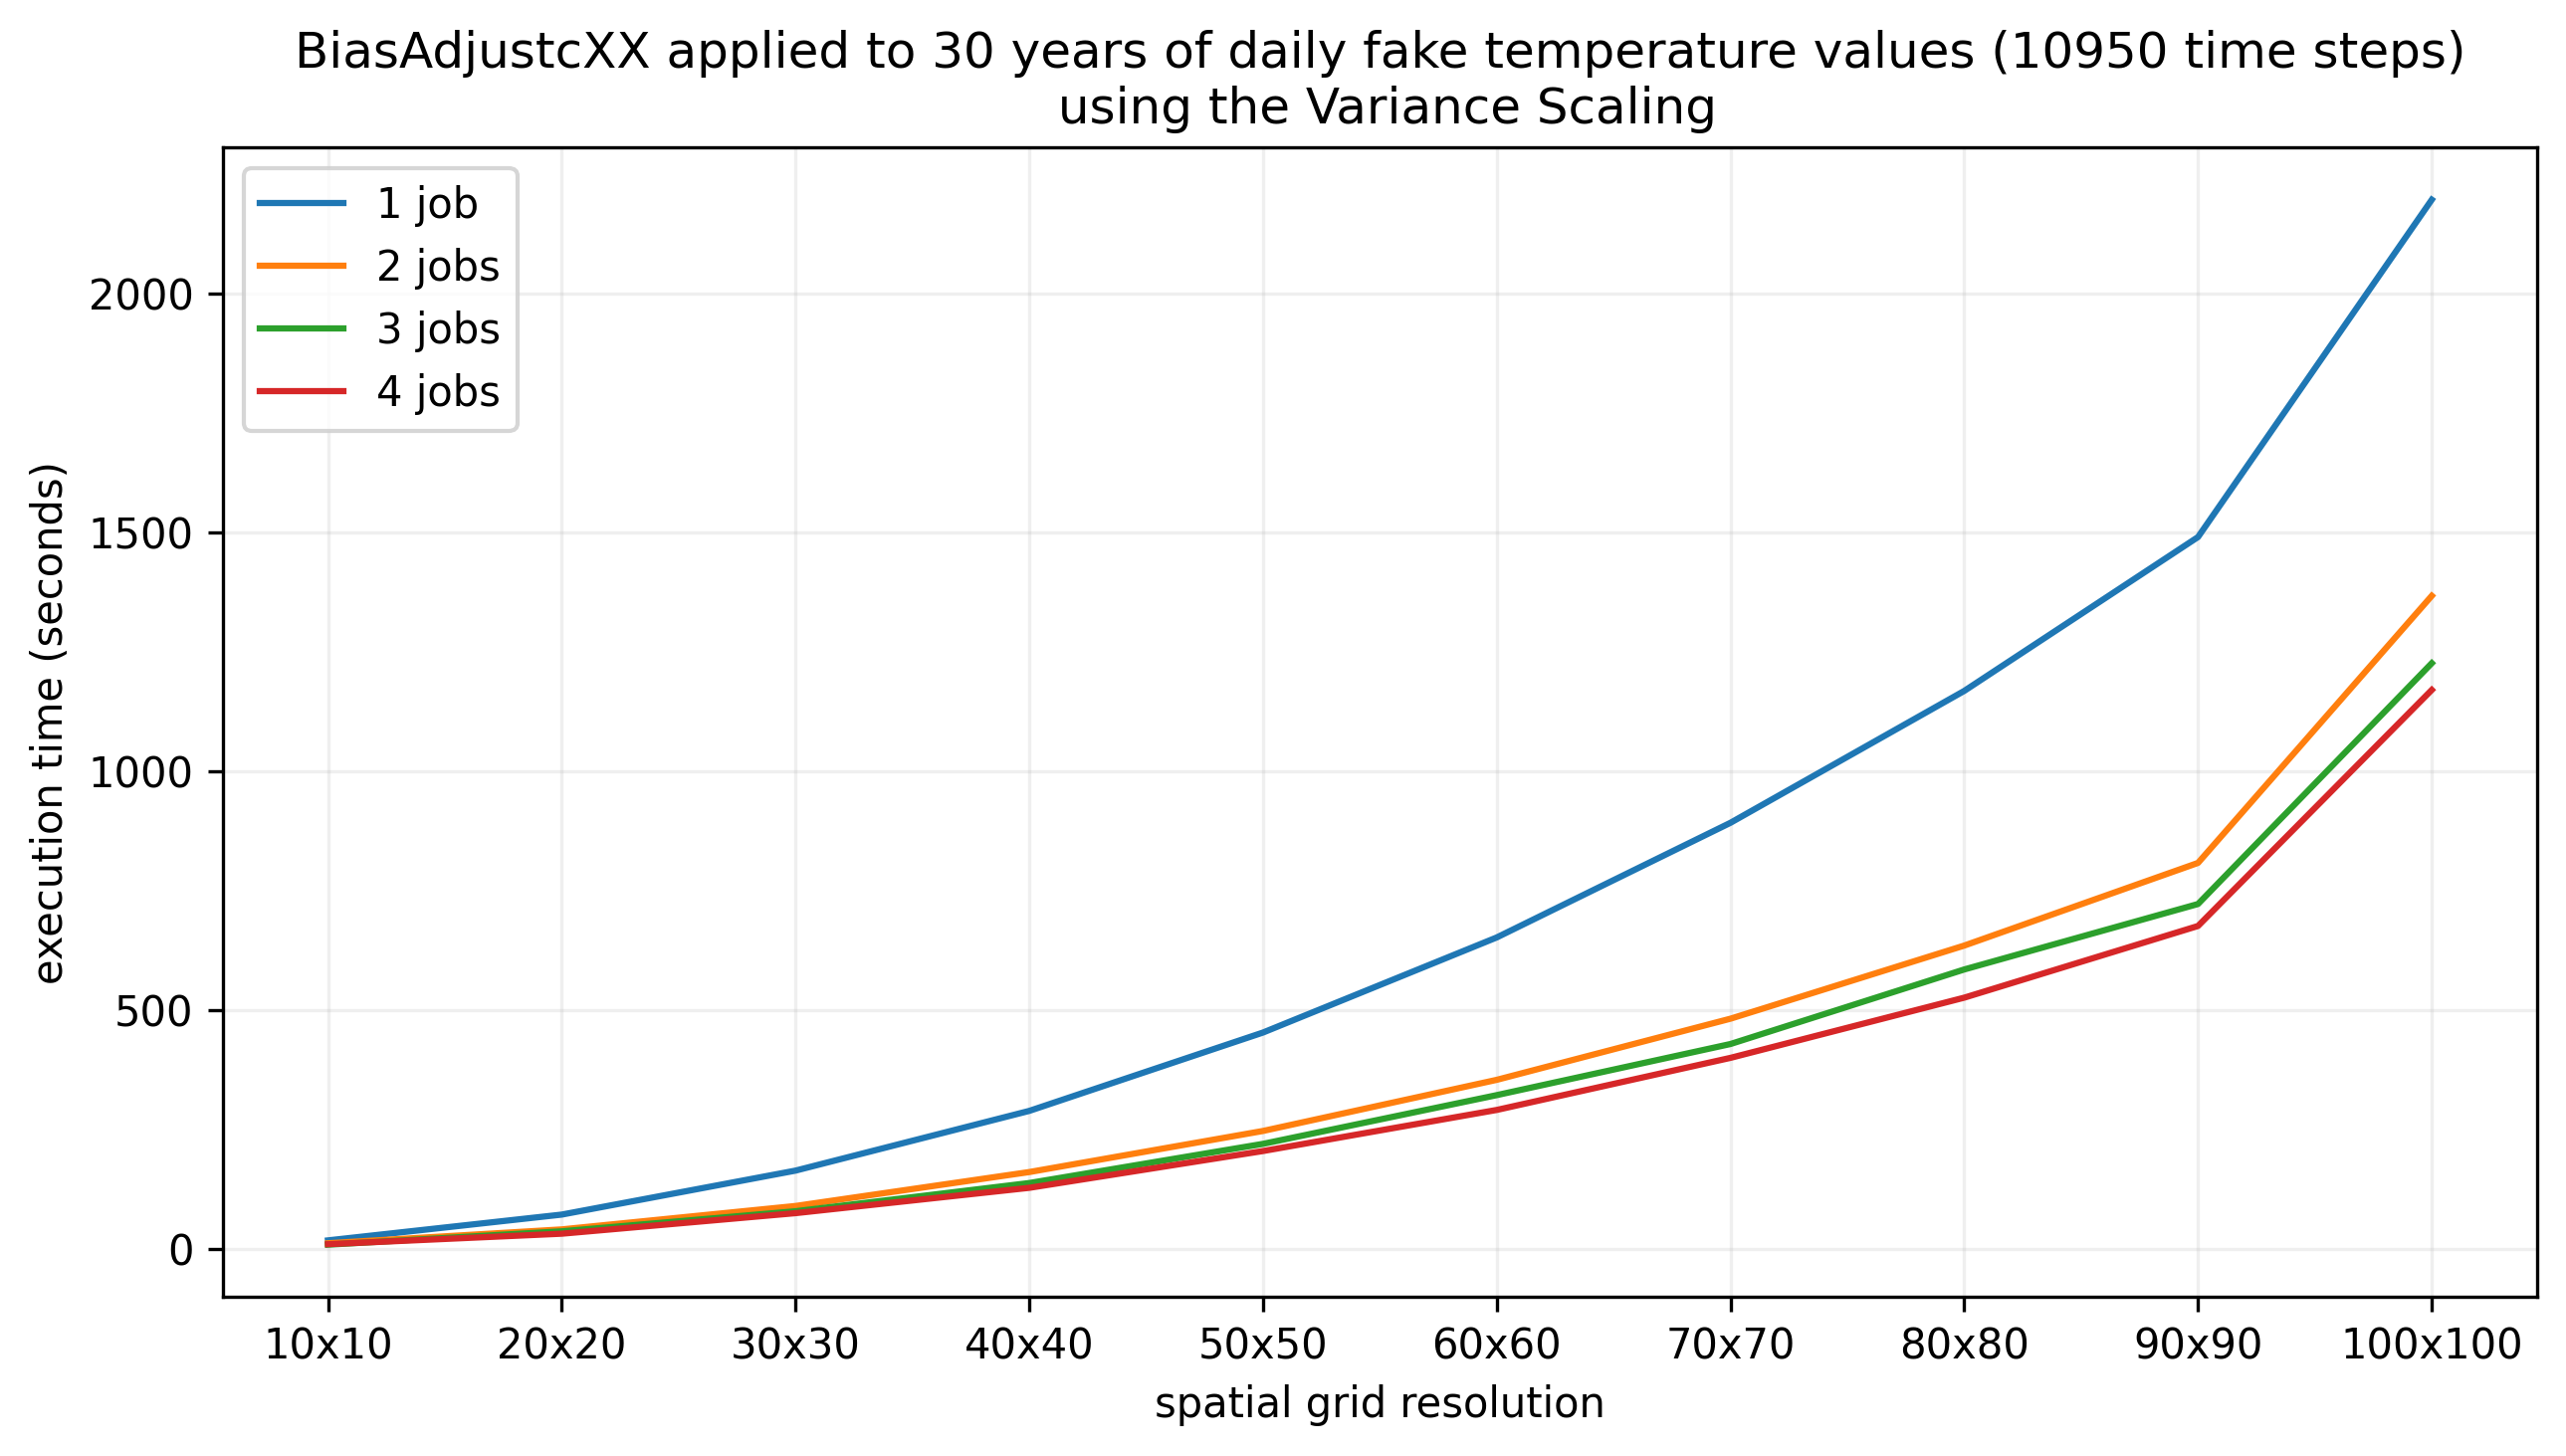

In [48]:
plt.figure(figsize=(10,5), dpi=300)

ax = plt.gca()
cxx_vs.groupby('jobs').plot(x='resolution', y='time (seconds)', ax=ax)
ax.legend([ '1 job', '2 jobs', '3 jobs', '4 jobs']);

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([f'{x}x{x}' for x in range(0,101,10)])
plt.grid(alpha=.2)

plt.ylabel('execution time (seconds)')
plt.xlabel('spatial grid resolution')
plt.title('BiasAdjustcXX applied to 30 years of daily fake temperature values (10950 time steps)\n using the Variance Scaling');

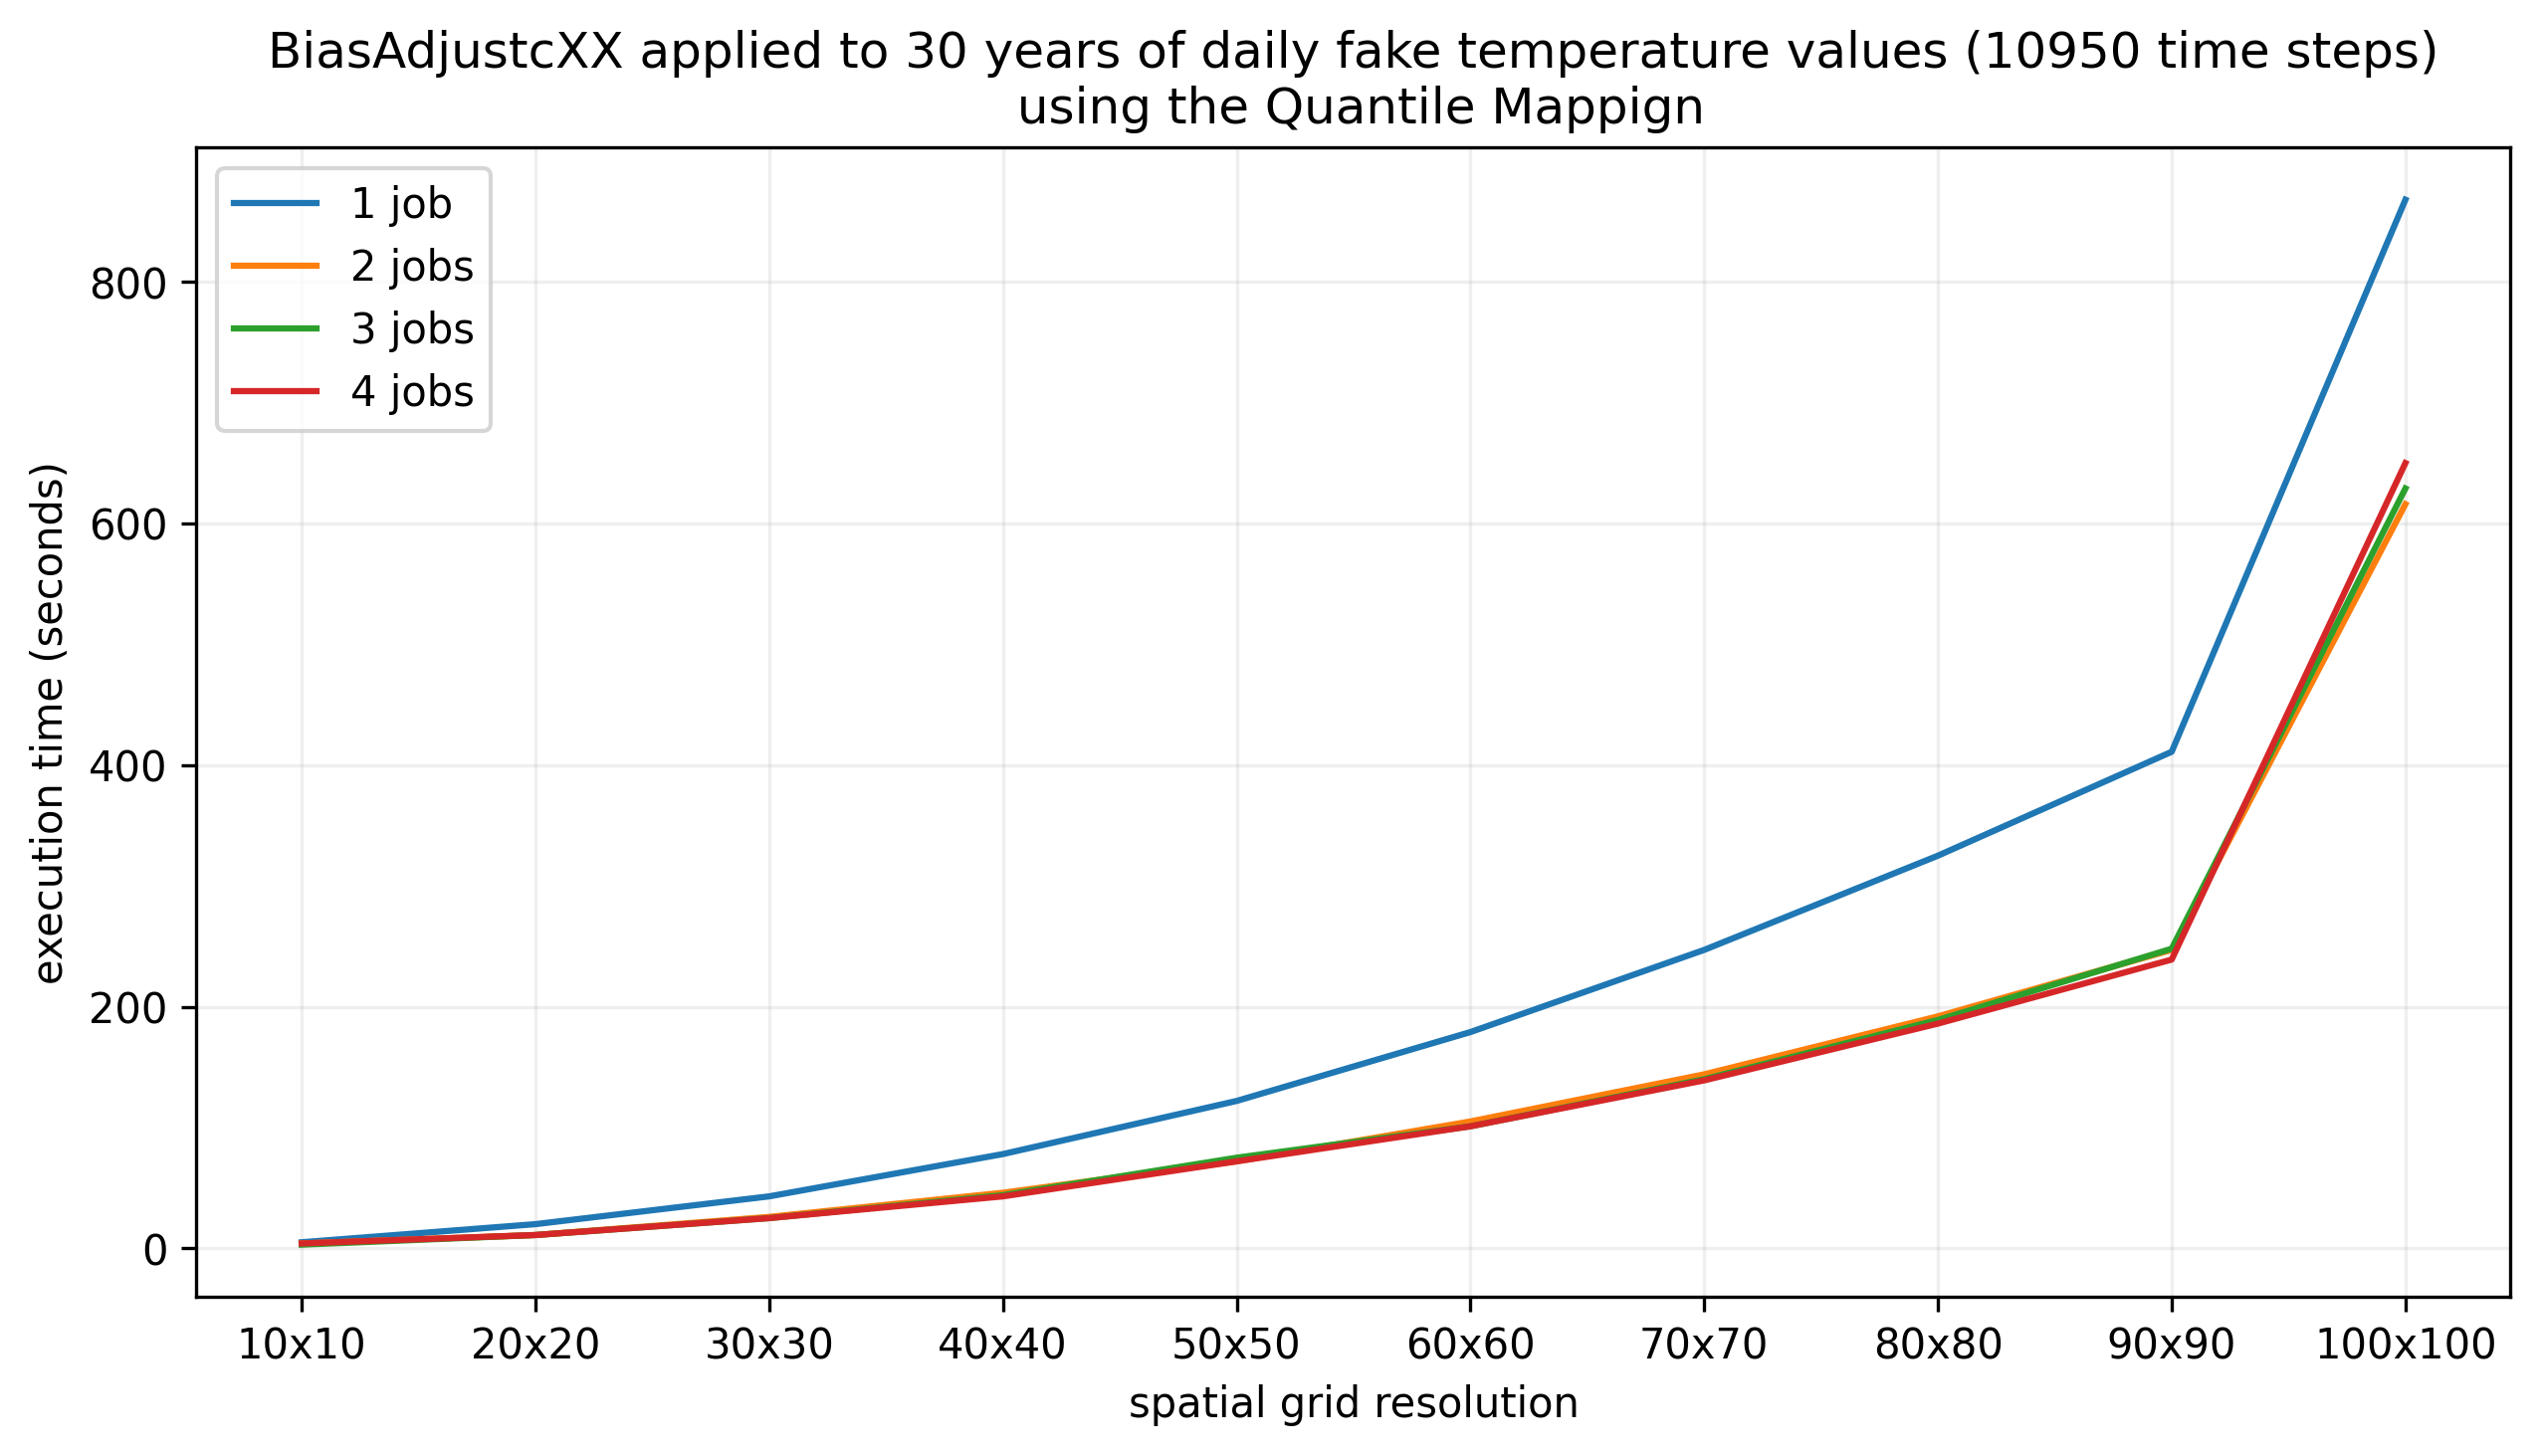

In [49]:
plt.figure(figsize=(10,5), dpi=300)

ax = plt.gca()
cxx_qm.groupby('jobs').plot(x='resolution', y='time (seconds)', ax=ax)
ax.legend([ '1 job', '2 jobs', '3 jobs', '4 jobs']);

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([f'{x}x{x}' for x in range(0,101,10)])
plt.grid(alpha=.2)

plt.ylabel('execution time (seconds)')
plt.xlabel('spatial grid resolution')
plt.title('BiasAdjustcXX applied to 30 years of daily fake temperature values (10950 time steps)\n using the Quantile Mappign');

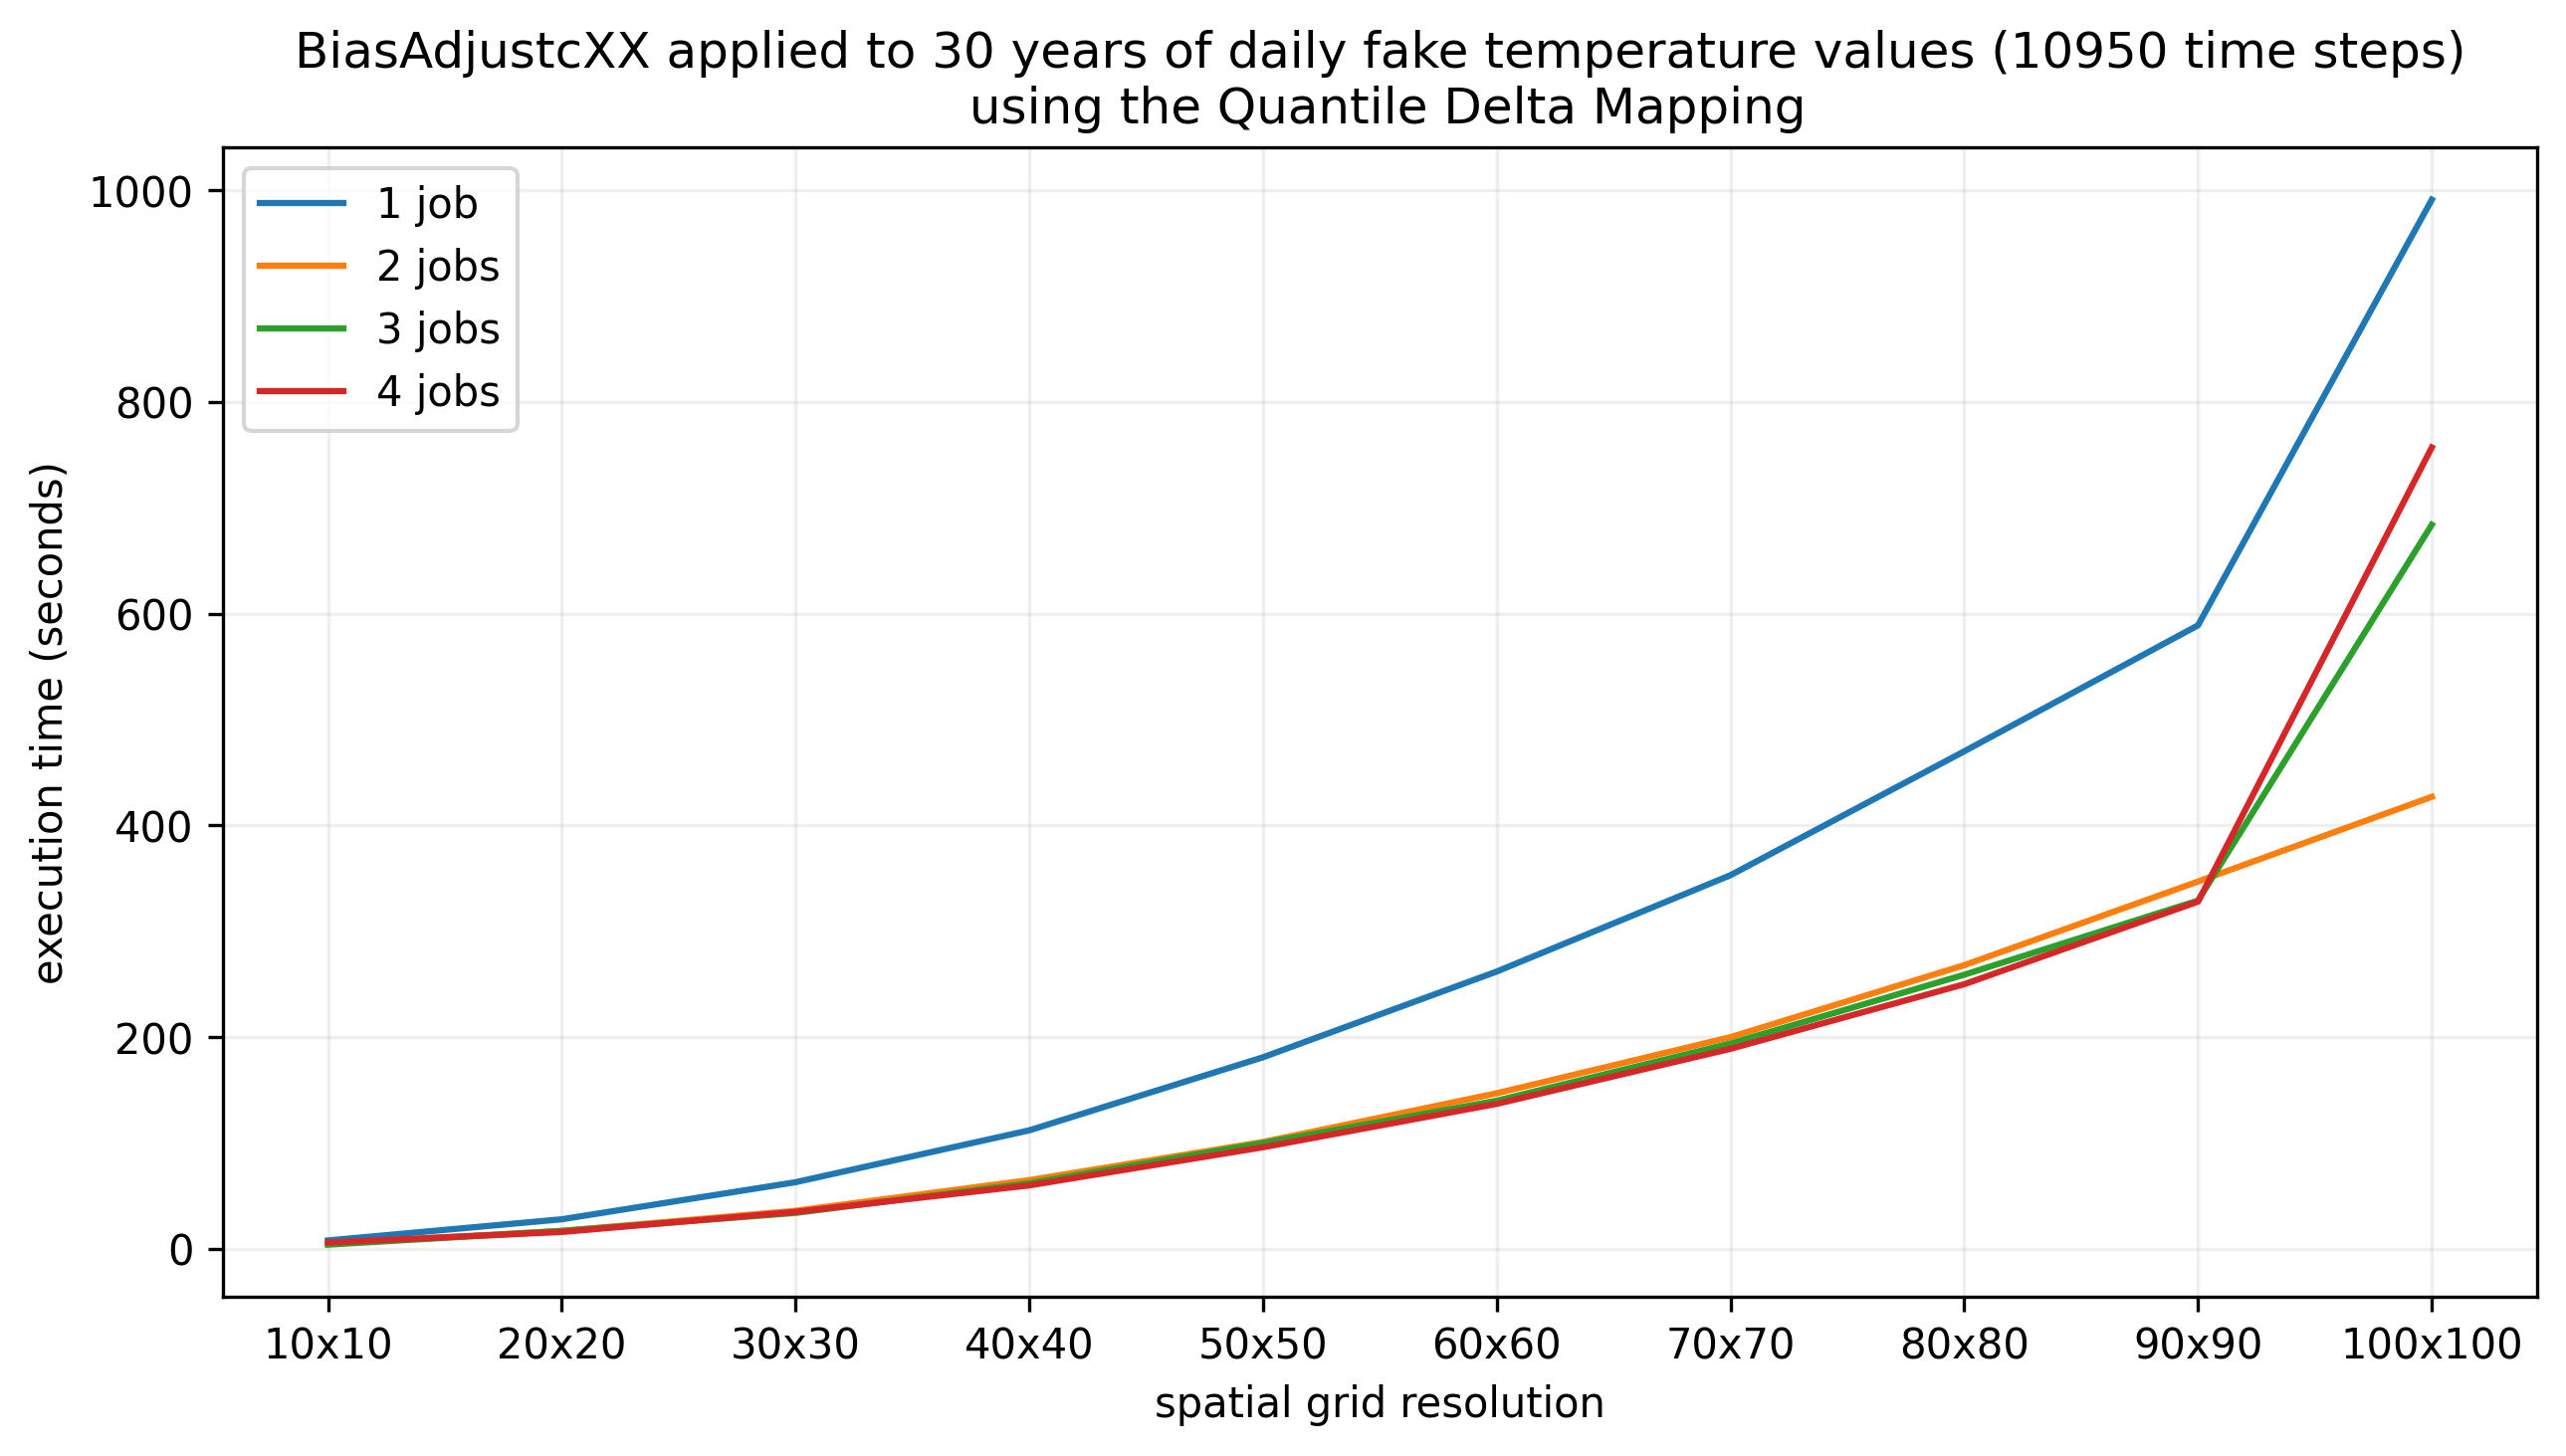

In [50]:
plt.figure(figsize=(10,5), dpi=300)

ax = plt.gca()
cxx_qdm.groupby('jobs').plot(x='resolution', y='time (seconds)', ax=ax)
ax.legend([ '1 job', '2 jobs', '3 jobs', '4 jobs']);

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([f'{x}x{x}' for x in range(0,101,10)])
plt.grid(alpha=.2)

plt.ylabel('execution time (seconds)')
plt.xlabel('spatial grid resolution')
plt.title('BiasAdjustcXX applied to 30 years of daily fake temperature values (10950 time steps)\n using the Quantile Delta Mapping');

### 4.2 Results of python-cmethods (QM and QDM)

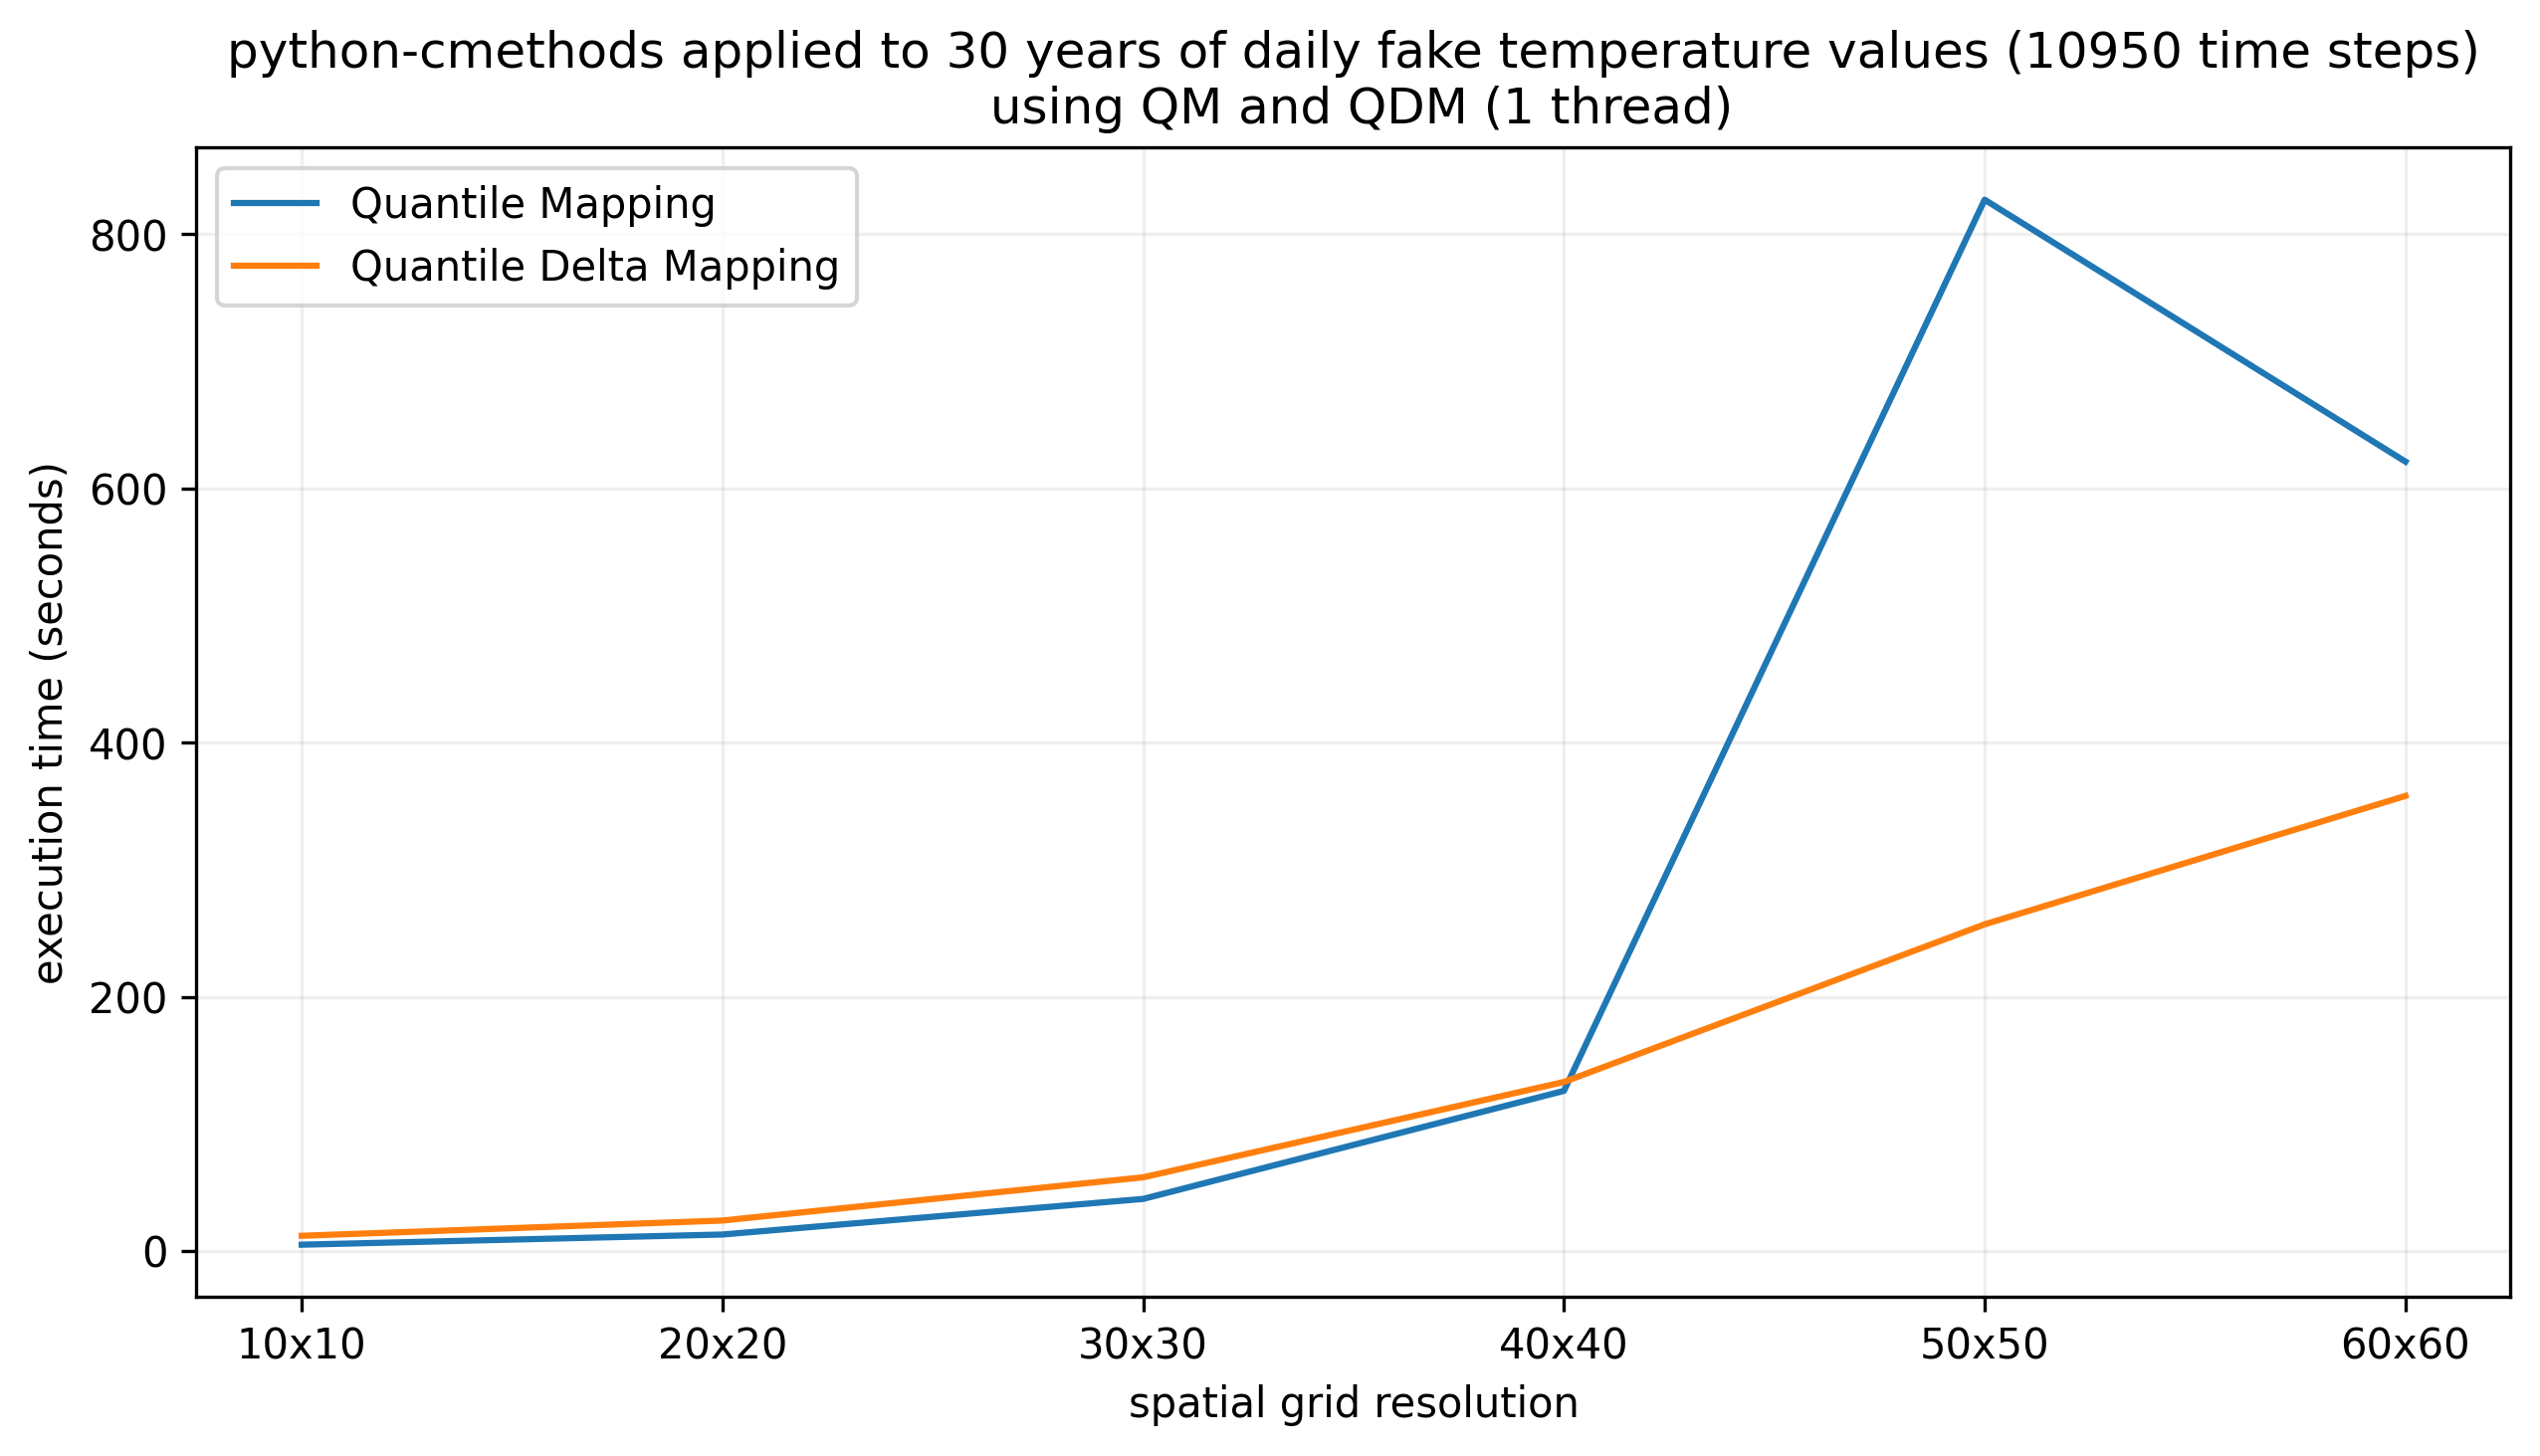

In [51]:
plt.figure(figsize=(10,5), dpi=300)

ax = plt.gca()
pycmethods_qm.plot(x='resolution', y='time (seconds)', ax=ax)
pycmethods_qdm.plot(x='resolution', y='time (seconds)', ax=ax)
ax.legend([ 'Quantile Mapping', 'Quantile Delta Mapping' ]);

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([f'{x}x{x}' for x in range(0,101,10)])
plt.grid(alpha=.2)

plt.ylabel('execution time (seconds)')
plt.xlabel('spatial grid resolution')
plt.title('python-cmethods applied to 30 years of daily fake temperature values (10950 time steps)\n using QM and QDM (1 thread)');


### 4.3 Results of xclim (QDM)

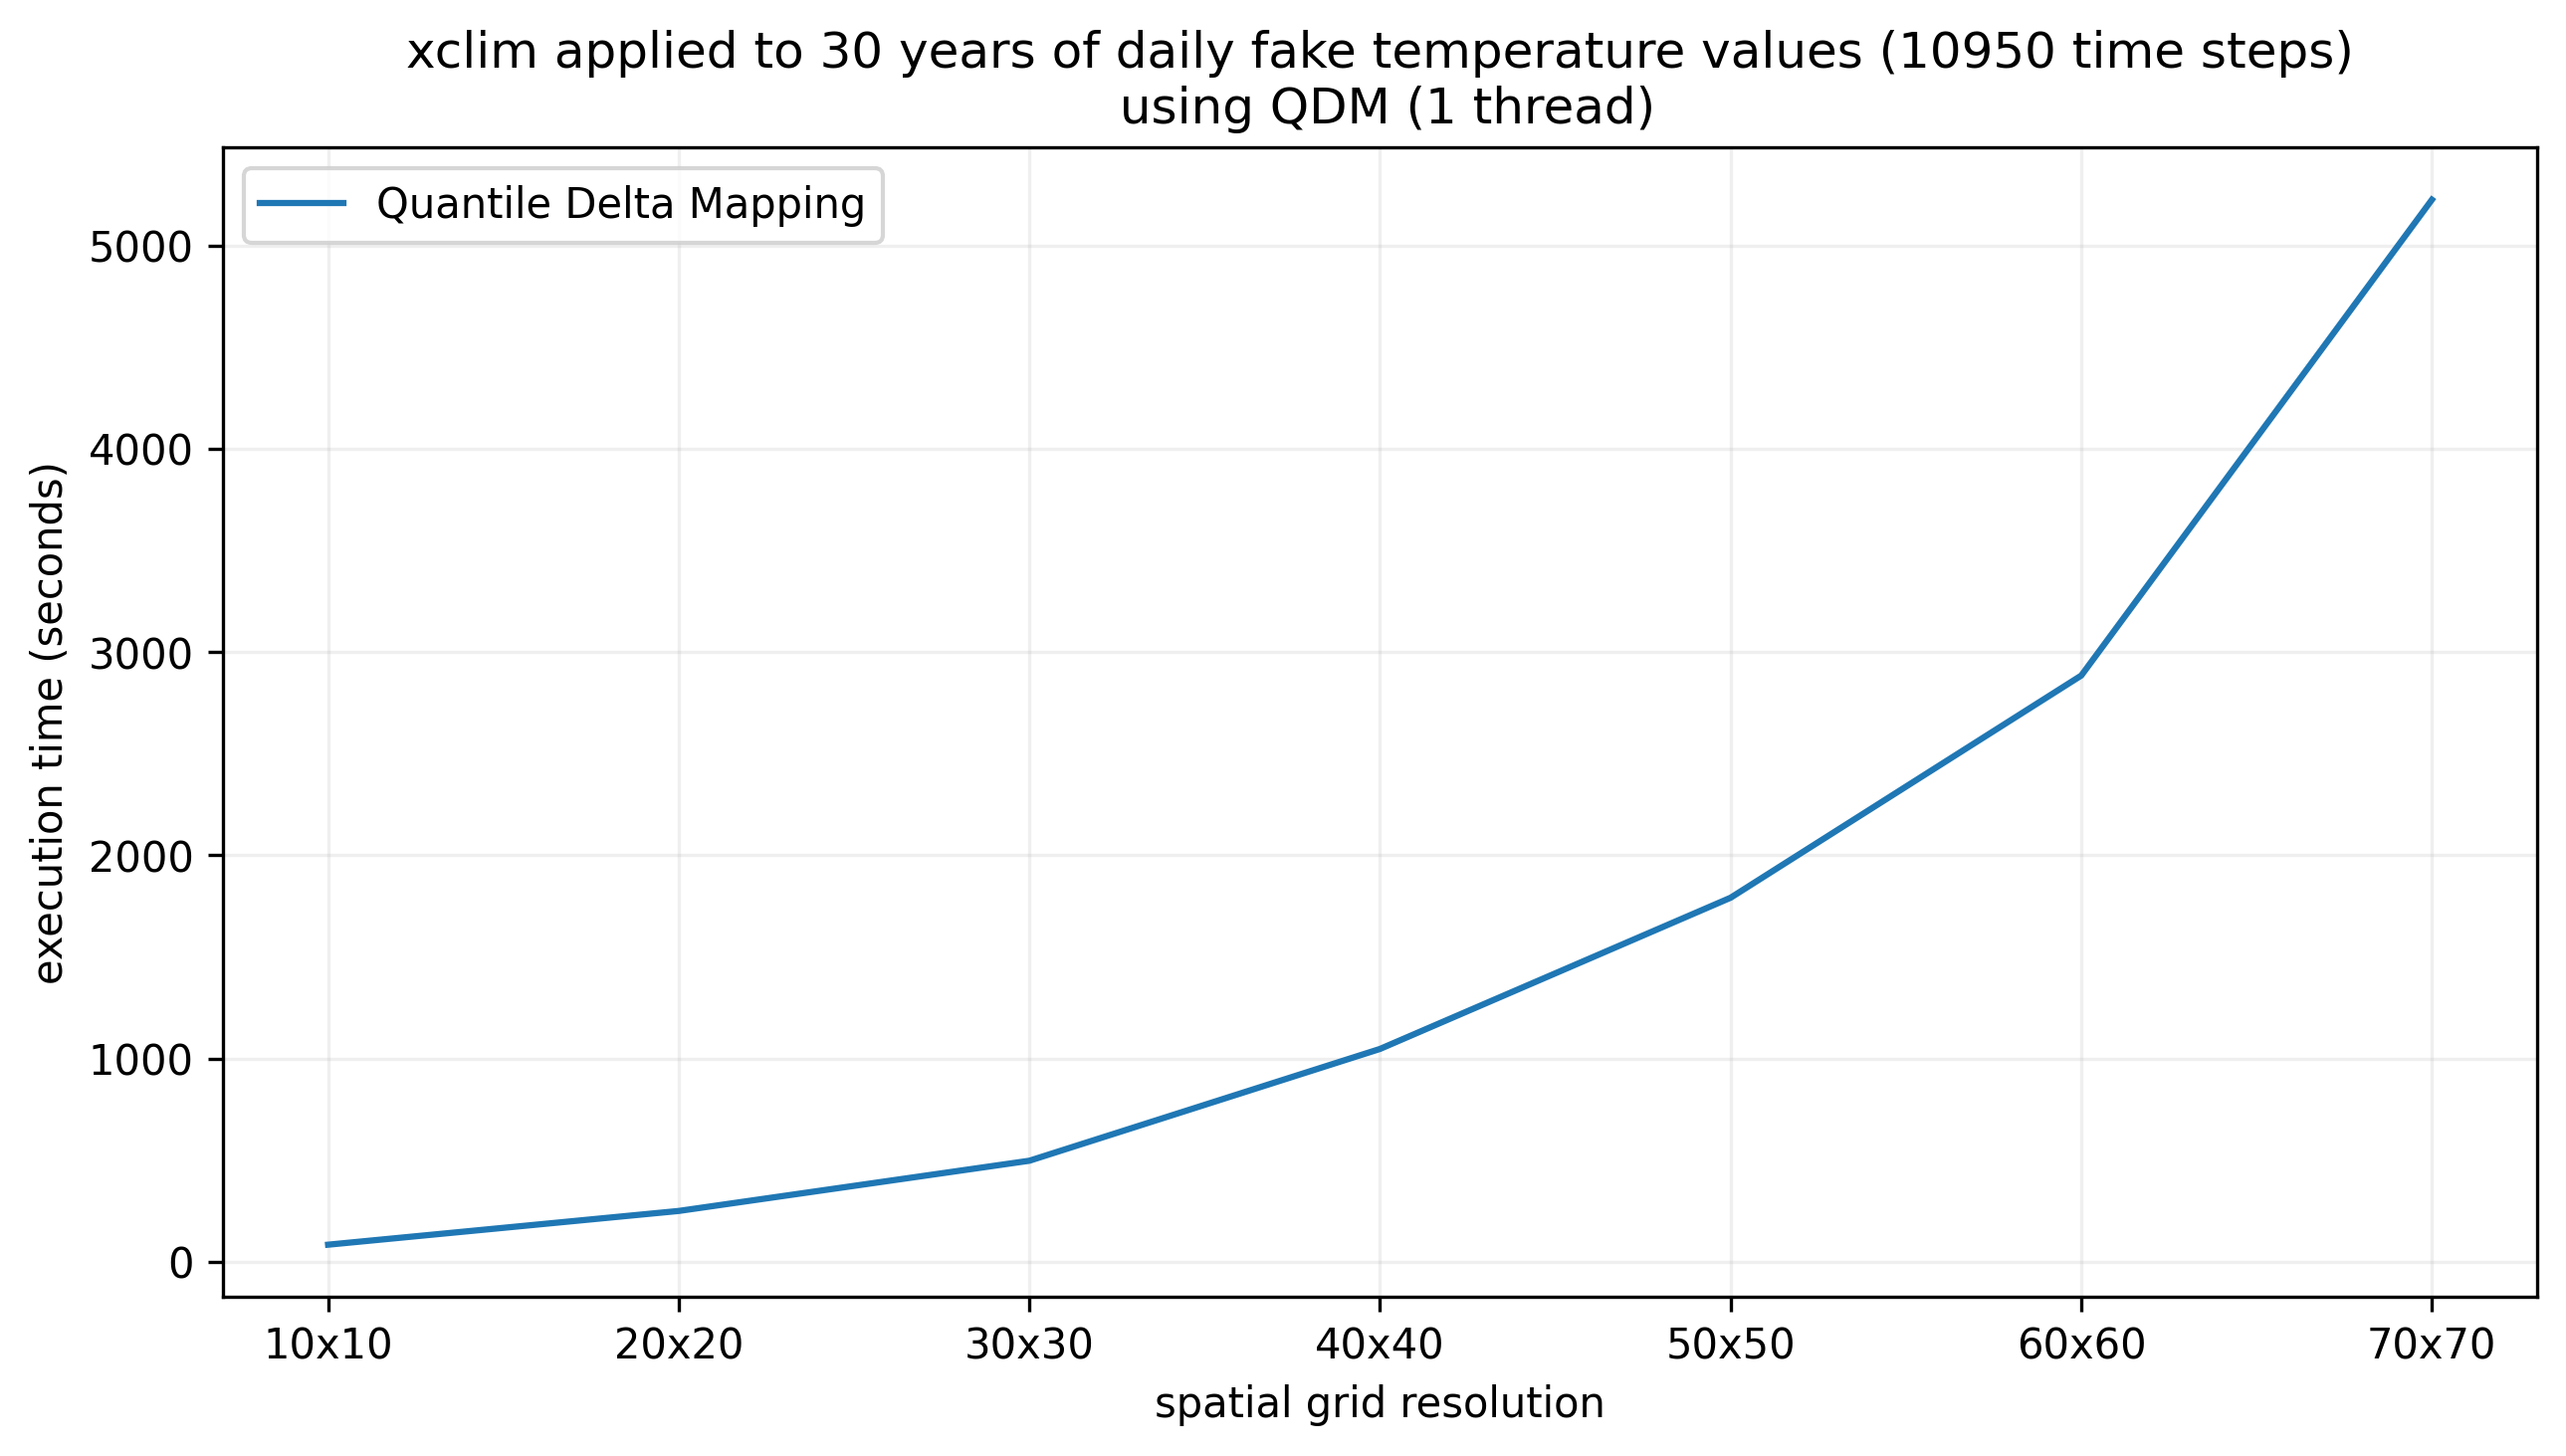

In [52]:
plt.figure(figsize=(10,5), dpi=300)

ax = plt.gca()
xclim_qdm.plot(x='resolution', y='time (seconds)', ax=ax)
ax.legend([ 'Quantile Delta Mapping' ]);

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([f'{x}x{x}' for x in range(0,101,10)])
plt.grid(alpha=.2)

plt.ylabel('execution time (seconds)')
plt.xlabel('spatial grid resolution')
plt.title('xclim applied to 30 years of daily fake temperature values (10950 time steps)\n using QDM (1 thread)');


### 4.4 Comparison of the execution time of QDM


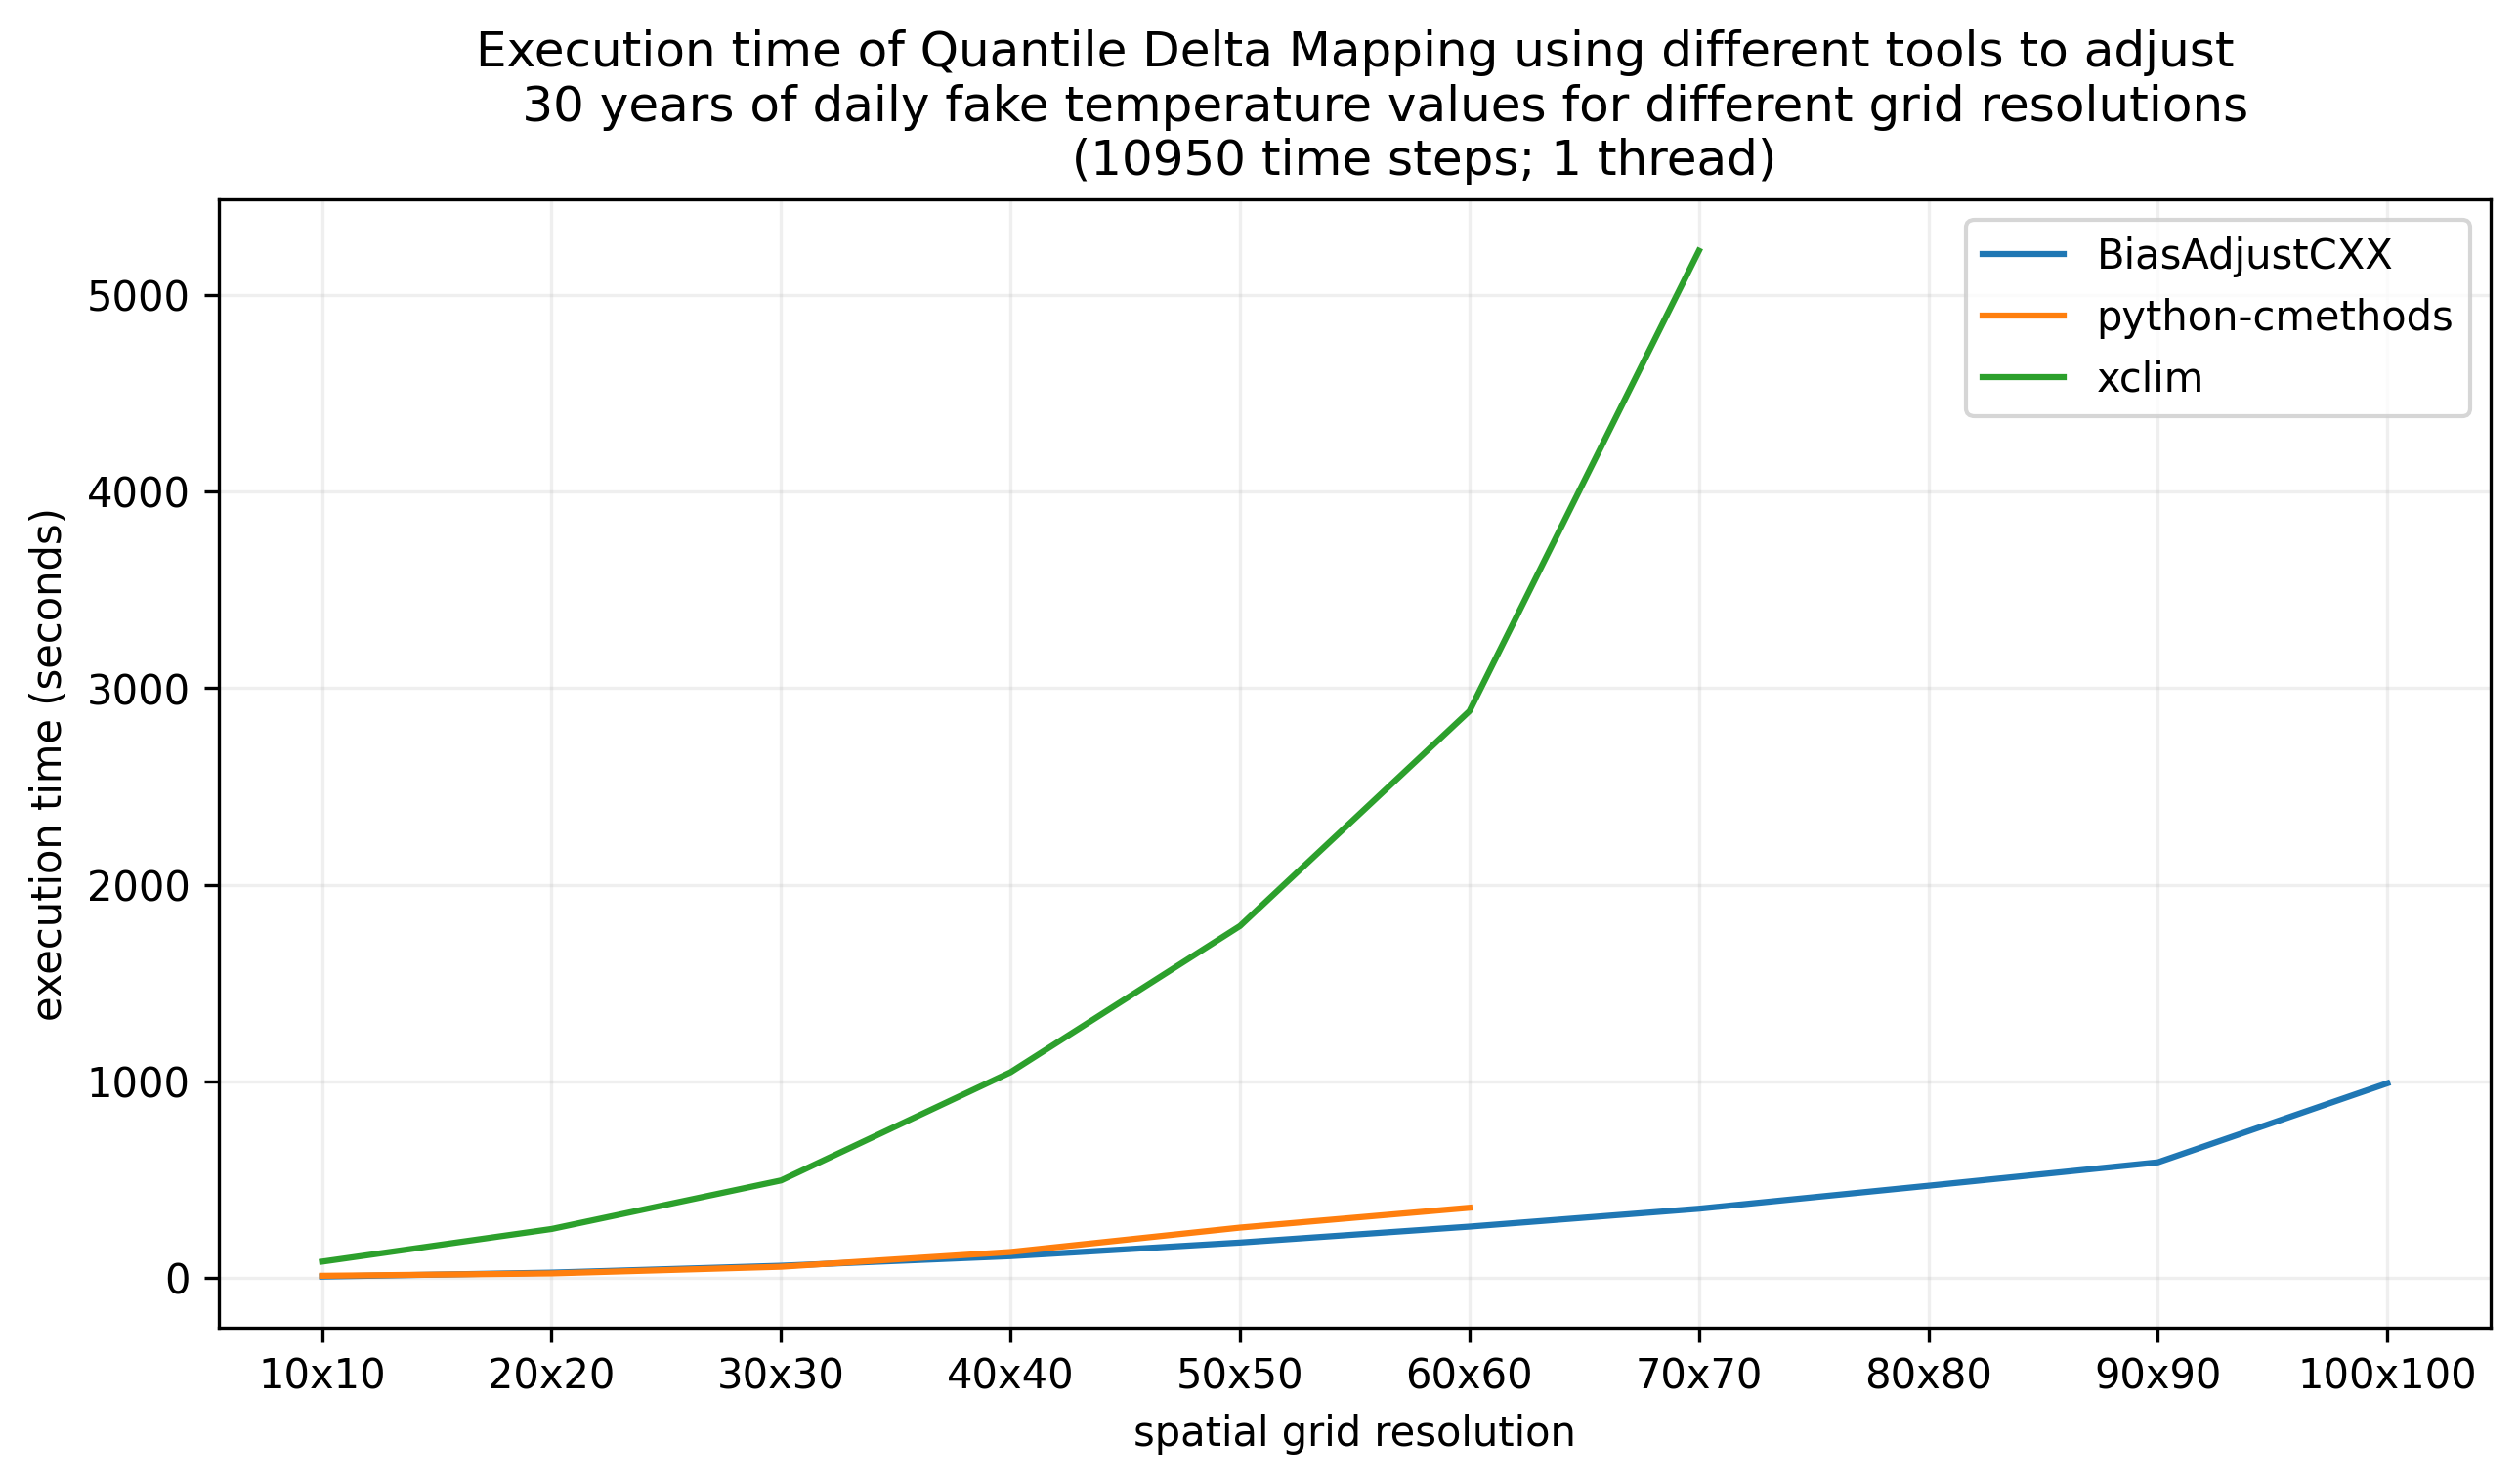

In [53]:
plt.figure(figsize=(10,5), dpi=300)

ax = plt.gca()
cxx_qdm.where(cxx_qdm['jobs'] == 1).plot(x='resolution', y='time (seconds)', ax=ax)
pycmethods_qdm.plot(x='resolution', y='time (seconds)', ax=ax)
xclim_qdm.plot(x='resolution', y='time (seconds)', ax=ax)
ax.legend([ 'BiasAdjustCXX', 'python-cmethods', 'xclim' ]);

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([f'{x}x{x}' for x in range(0,101,10)])
plt.grid(alpha=.2)

plt.ylabel('execution time (seconds)')
plt.xlabel('spatial grid resolution')
plt.title('Execution time of Quantile Delta Mapping using different tools to adjust\n \
    30 years of daily fake temperature values for different grid resolutions \n \
        (10950 time steps; 1 thread)');
